In [33]:
# Standard Libraries
import os
import logging
from typing import List, Dict, Tuple, Any, Optional, Union, Sized # For type hinting

# Data Handling
import numpy as np
import pandas as pd

# Machine Learning - Preprocessing & Metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Imbalanced Learning
from imblearn.over_sampling import SMOTE

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import joblib

# --- SETUP ---
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure logging
logging.basicConfig(
    filename='transformer_fault_analysis.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='w',
    force=True # Allows reconfiguring logger in Jupyter if the cell is re-run
)
logging.info("Notebook execution started.")

# Determine device
DEVICE: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {DEVICE}")

In [34]:
# Load the dataset
try:
    df = pd.read_csv('Health index1.csv')
    logging.info(f"Successfully loaded 'Health index1.csv'. Shape: {df.shape}")
except FileNotFoundError:
    logging.error("'Health index1.csv' not found. Please ensure the file is in the correct directory.")
    df = pd.DataFrame()

if not df.empty:
    print("Dataset Information:")
    df.info()
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    required_gas_columns = ['Methane', 'Ethylene', 'Acethylene', 'Hydrogen', 'Ethane']
    required_other_columns = ['Health index']

    missing_cols = [col for col in required_gas_columns + required_other_columns if col not in df.columns]
    if missing_cols:
        err_msg = f"Critical error: Dataset is missing required columns: {missing_cols}."
        logging.error(err_msg)
        raise ValueError(err_msg)
    else:
        logging.info("All critical DGA and Health Index columns are present.")
else:
    logging.warning("DataFrame is empty after attempting to load data.")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Hydrogen             470 non-null    int64  
 1   Oxigen               470 non-null    int64  
 2   Nitrogen             470 non-null    int64  
 3   Methane              470 non-null    int64  
 4   CO                   470 non-null    int64  
 5   CO2                  470 non-null    int64  
 6   Ethylene             470 non-null    int64  
 7   Ethane               470 non-null    int64  
 8   Acethylene           470 non-null    int64  
 9   DBDS                 470 non-null    float64
 10  Power factor         470 non-null    float64
 11  Interfacial V        470 non-null    int64  
 12  Dielectric rigidity  470 non-null    int64  
 13  Water content        470 non-null    int64  
 14  Health index         470 non-null    float64
 15  Life expectation   

In [35]:
# --- Diagnostic Logic Functions ---
# (Keeping the functions as previously defined, assuming their internal logic is okay for now,
# as Pylance errors didn't target their internal logic directly, only how their results might be used.)

def duval_triangle_fault_type(ch4_pct: float, c2h4_pct: float, c2h2_pct: float) -> str:
    if not ((-0.1 <= ch4_pct <= 100.1) and \
            (-0.1 <= c2h4_pct <= 100.1) and \
            (-0.1 <= c2h2_pct <= 100.1)):
        logging.warning(f"Invalid input percentages for Duval: CH4={ch4_pct}, C2H4={c2h4_pct}, C2H2={c2h2_pct}")
        return "Error_InvalidInput"
    if ch4_pct < 0.1 and c2h4_pct < 0.1 and c2h2_pct < 0.1:
        return "NF"
    if ch4_pct >= 98: return "PD"
    if c2h2_pct >= 29 and c2h4_pct < 20: return "D1"
    if c2h2_pct >= 29 and c2h4_pct >= 20 :return "D2"
    if c2h2_pct < 29 and c2h4_pct >= 50: return "T3"
    if c2h2_pct < 4 and 20 <= c2h4_pct < 50: return "T2"
    if c2h2_pct < 4 and c2h4_pct < 20: return "T1"
    if 4 <= c2h2_pct < 29 and c2h4_pct < 50: return "DT"
    return "NF_Undetermined"

def adjust_fault_label(duval_label: str, health_index: float) -> str:
    if duval_label == "Error_InvalidInput": return "Error_InvalidInput"
    if health_index >= 85 and duval_label not in ["NF", "NF_Undetermined"]: return "NF"
    if health_index < 30:
        if duval_label in ["PD", "T1", "NF_Undetermined", "NF", "DT"]: return "D1"
        if duval_label == "T2": return "T3"
        return duval_label
    elif 30 <= health_index < 50:
        if duval_label in ["PD", "NF_Undetermined", "NF"]: return "T1"
        if duval_label == "T1": return "T2"
        if duval_label == "DT": return "D1"
        return duval_label
    return duval_label

logging.info("Diagnostic functions defined.")

In [36]:
if not df.empty:
    df['Total_Key_Gases_Duval'] = df[['Methane', 'Ethylene', 'Acethylene']].sum(axis=1)
    df['CH4_pct_Duval'] = np.where(df['Total_Key_Gases_Duval'] == 0, 0.0, (df['Methane'] / df['Total_Key_Gases_Duval']) * 100)
    df['C2H4_pct_Duval'] = np.where(df['Total_Key_Gases_Duval'] == 0, 0.0, (df['Ethylene'] / df['Total_Key_Gases_Duval']) * 100)
    df['C2H2_pct_Duval'] = np.where(df['Total_Key_Gases_Duval'] == 0, 0.0, (df['Acethylene'] / df['Total_Key_Gases_Duval']) * 100)
    duval_pct_cols = ['CH4_pct_Duval', 'C2H4_pct_Duval', 'C2H2_pct_Duval']
    df[duval_pct_cols] = df[duval_pct_cols].fillna(0.0)
    logging.info("Calculated Duval gas percentages.")

    gas_ratio_pairs = {
        'CH4_H2': ('Methane', 'Hydrogen'), 'C2H6_CH4': ('Ethane', 'Methane'),
        'C2H4_C2H6': ('Ethylene', 'Ethane'), 'C2H2_C2H4': ('Acethylene', 'Ethylene')
    }
    for ratio_name, (num_gas, den_gas) in gas_ratio_pairs.items():
        if num_gas in df.columns and den_gas in df.columns:
            denominator = df[den_gas].replace(0, np.nan)
            df[ratio_name] = df[num_gas] / denominator
        else:
            logging.warning(f"Columns for ratio {ratio_name} not found. Setting ratio to 0.0.")
            df[ratio_name] = 0.0
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    ratio_cols = list(gas_ratio_pairs.keys())
    df[ratio_cols] = df[ratio_cols].fillna(0.0)
    logging.info("Calculated gas ratios and handled NaNs/Infs.")
    print("\nPreview of DataFrame with new gas features (first 5 rows):")
    print(df[duval_pct_cols + ratio_cols + ['Total_Key_Gases_Duval']].head())
else:
    logging.warning("DataFrame is empty, skipping feature engineering.")


Preview of DataFrame with new gas features (first 5 rows):
   CH4_pct_Duval  C2H4_pct_Duval  C2H2_pct_Duval    CH4_H2  C2H6_CH4  \
0      30.734116       69.236834        0.029049  2.603163  0.738185   
1      99.545970        0.454030        0.000000  0.068058  0.347777   
2       5.669291        8.110236       86.220472  0.051064  0.076389   
3      98.911071        1.088929        0.000000  0.495905  0.422018   
4      95.238095        2.380952        2.380952  0.049844  0.268750   

   C2H4_C2H6  C2H2_C2H4  Total_Key_Gases_Duval  
0   3.051765   0.000420                  24097  
1   0.013115   0.000000                    881  
2  18.727273  10.631068                   2540  
3   0.026087   0.000000                    551  
4   0.093023   1.000000                    168  


In [37]:
if not df.empty:
    df['Duval_Label_Raw'] = df.apply(
        lambda row: duval_triangle_fault_type(row['CH4_pct_Duval'], row['C2H4_pct_Duval'], row['C2H2_pct_Duval']), axis=1
    )
    df['Fault_Type_Raw'] = df.apply(
        lambda row: adjust_fault_label(row['Duval_Label_Raw'], row['Health index']), axis=1
    )
    logging.info("Derived initial 'Fault_Type_Raw'.")

    print("\n--- Initial Fault Type Distribution ('Fault_Type_Raw') ---")
    initial_fault_counts = df['Fault_Type_Raw'].value_counts()
    print(initial_fault_counts)
    total_samples = len(df) # Store total samples
    print(f"\nTotal samples: {total_samples}")

    print("\n--- Rare Class Analysis (for 'Fault_Type_Raw') ---")
    threshold_absolute = 20
    identified_rare_classes = [
        lbl for lbl, count in initial_fault_counts.items()
        if count < threshold_absolute and lbl not in ["NF", "NF_Undetermined", "Error_InvalidInput"]
    ]
    for class_label, count in initial_fault_counts.items():
        status = "RARE" if class_label in identified_rare_classes else "NOT RARE"
        if class_label in ["NF", "NF_Undetermined", "Error_InvalidInput"]: status = "CONTROL/ERROR"
        print(f"Class '{class_label}': Count={count} ({(count/total_samples)*100:.2f}%) - Status: {status}")

    print(f"\nPotentially rare classes for merging consideration: {identified_rare_classes}")
    logging.info(f"Initial Fault_Type_Raw distribution:\n{initial_fault_counts}")
    logging.info(f"Potentially rare classes for merging: {identified_rare_classes}")

    df = df[df['Fault_Type_Raw'] != 'Error_InvalidInput'].copy() # Use .copy() to avoid SettingWithCopyWarning
    logging.info(f"Removed rows with 'Error_InvalidInput'. New shape: {df.shape}")
else:
    logging.warning("DataFrame is empty, skipping fault type derivation.")


--- Initial Fault Type Distribution ('Fault_Type_Raw') ---
Fault_Type_Raw
T3    182
D1    169
T1     57
T2     38
PD      8
D2      7
NF      5
DT      4
Name: count, dtype: int64

Total samples: 470

--- Rare Class Analysis (for 'Fault_Type_Raw') ---
Class 'T3': Count=182 (38.72%) - Status: NOT RARE
Class 'D1': Count=169 (35.96%) - Status: NOT RARE
Class 'T1': Count=57 (12.13%) - Status: NOT RARE
Class 'T2': Count=38 (8.09%) - Status: NOT RARE
Class 'PD': Count=8 (1.70%) - Status: RARE
Class 'D2': Count=7 (1.49%) - Status: RARE
Class 'NF': Count=5 (1.06%) - Status: CONTROL/ERROR
Class 'DT': Count=4 (0.85%) - Status: RARE

Potentially rare classes for merging consideration: ['PD', 'D2', 'DT']


In [38]:
if not df.empty and 'Fault_Type_Raw' in df.columns:
    # Based on the provided distribution: T1=288, D2=135, PD=17, T3=15, D1=10, NF=5
    # Merging PD (17) and D1 (10) as they are rare and discharge-related.
    custom_merge_map: Dict[str, str] = { # Type hint added
       'PD': 'Low_Med_Energy_Discharge',
       'D1': 'Low_Med_Energy_Discharge',
       # T3 (15) and NF (5) will remain separate but are noted as small.
    }
    logging.info(f"Using custom_merge_map: {custom_merge_map}")

    def merge_classes_fn(label: str, merge_map: Optional[Dict[str, str]]) -> str:
        if merge_map and label in merge_map:
            return merge_map[label]
        return label

    df['Fault_Type_Merged'] = df['Fault_Type_Raw'].apply(lambda x: merge_classes_fn(x, custom_merge_map))
    
    final_text_labels_for_encoding = df['Fault_Type_Merged']
    print("\nFault Type Distribution After Merging:")
    merged_counts = final_text_labels_for_encoding.value_counts()
    print(merged_counts)
    logging.info(f"Fault_Type distribution after merging:\n{merged_counts}")

    if final_text_labels_for_encoding.isna().any():
        nan_count = final_text_labels_for_encoding.isna().sum()
        logging.warning(f"NaN values found in 'Fault_Type_Merged' before encoding. Dropping {nan_count} rows.")
        df.dropna(subset=['Fault_Type_Merged'], inplace=True)
        final_text_labels_for_encoding = df['Fault_Type_Merged']

    label_encoder = LabelEncoder()
    df['Fault_Label_Encoded'] = label_encoder.fit_transform(final_text_labels_for_encoding)

    logging.info(f"Label encoder classes: {list(label_encoder.classes_)}")
    joblib.dump(label_encoder, 'label_encoder_final.gz')
    logging.info("Saved final label encoder.")

    print("\nFinal Encoded Label Distribution:")
    # Corrected rename logic for Pylance
    encoded_value_counts = df['Fault_Label_Encoded'].value_counts().sort_index()
    idx_to_name_map = {idx: label_encoder.classes_[idx] for idx in encoded_value_counts.index}
    encoded_counts_display = encoded_value_counts.rename(index=idx_to_name_map)
    print(encoded_counts_display)
else:
    logging.warning("DataFrame is empty or 'Fault_Type_Raw' not available, skipping label preprocessing.")


Fault Type Distribution After Merging:
Fault_Type_Merged
T3                          182
Low_Med_Energy_Discharge    177
T1                           57
T2                           38
D2                            7
NF                            5
DT                            4
Name: count, dtype: int64

Final Encoded Label Distribution:
Fault_Label_Encoded
D2                            7
DT                            4
Low_Med_Energy_Discharge    177
NF                            5
T1                           57
T2                           38
T3                          182
Name: count, dtype: int64


In [39]:
if not df.empty and 'Fault_Label_Encoded' in df.columns:
    features: List[str] = [
        'Hydrogen', 'Oxigen', 'Nitrogen', 'Methane', 'CO', 'CO2', 'Ethylene',
        'Ethane', 'Acethylene', 'DBDS', 'Power factor', 'Interfacial V',
        'Dielectric rigidity', 'Water content', 'Life expectation',
        'CH4_H2', 'C2H6_CH4', 'C2H4_C2H6', 'C2H2_C2H4'
    ]
    actual_features_in_df = [f for f in features if f in df.columns]
    missing_defined_features = [f for f in features if f not in df.columns]
    if missing_defined_features:
        logging.warning(f"Defined features not found and excluded: {missing_defined_features}")
    
    if not actual_features_in_df:
        raise ValueError("No defined features are present in the DataFrame.")

    X_df_unprocessed: pd.DataFrame = df[actual_features_in_df].copy()
    y_encoded_series: pd.Series = df['Fault_Label_Encoded'].copy()

    common_index = X_df_unprocessed.index.intersection(y_encoded_series.index)
    X_df_unprocessed = X_df_unprocessed.loc[common_index]
    y_encoded_series = y_encoded_series.loc[common_index]
    
    logging.info(f"Selected {len(actual_features_in_df)} features. X shape: {X_df_unprocessed.shape}, y shape: {y_encoded_series.shape}")
    print(f"\nFeatures selected for X ({len(actual_features_in_df)}): {actual_features_in_df}")
else:
    logging.warning("DataFrame/target not ready, skipping feature selection.")
    X_df_unprocessed = pd.DataFrame()
    y_encoded_series = pd.Series(dtype='int')


Features selected for X (19): ['Hydrogen', 'Oxigen', 'Nitrogen', 'Methane', 'CO', 'CO2', 'Ethylene', 'Ethane', 'Acethylene', 'DBDS', 'Power factor', 'Interfacial V', 'Dielectric rigidity', 'Water content', 'Life expectation', 'CH4_H2', 'C2H6_CH4', 'C2H4_C2H6', 'C2H2_C2H4']


In [40]:
if not X_df_unprocessed.empty:
    all_nan_cols = X_df_unprocessed.columns[X_df_unprocessed.isna().all()].tolist()
    if all_nan_cols:
        logging.warning(f"Dropping all-NaN columns before imputation: {all_nan_cols}")
        X_df_unprocessed.drop(columns=all_nan_cols, inplace=True)
        actual_features_in_df = X_df_unprocessed.columns.tolist() # Update feature list

    if X_df_unprocessed.isna().sum().sum() > 0:
        logging.info(f"Missing values in X before imputation: \n{X_df_unprocessed.isna().sum()[X_df_unprocessed.isna().sum() > 0]}")
        imputer = KNNImputer(n_neighbors=5)
        X_imputed_array: np.ndarray = imputer.fit_transform(X_df_unprocessed)
        X_imputed_df: pd.DataFrame = pd.DataFrame(X_imputed_array, columns=X_df_unprocessed.columns, index=X_df_unprocessed.index)
        if X_imputed_df.isna().sum().sum() > 0:
            logging.warning("Missing values STILL remain after KNN. Filling with 0.")
            X_imputed_df.fillna(0, inplace=True)
    else:
        logging.info("No missing values in X. Skipping KNNImputer.")
        X_imputed_df = X_df_unprocessed.copy()
    
    scaler = StandardScaler()
    X_scaled_array: np.ndarray = scaler.fit_transform(X_imputed_df)
    X_scaled_df: pd.DataFrame = pd.DataFrame(X_scaled_array, columns=X_imputed_df.columns, index=X_imputed_df.index)
    
    joblib.dump(scaler, 'scaler_fitted_on_full_data.gz')
    logging.info("Applied StandardScaler and saved general scaler.")
    print("\nPreview of scaled features (X_scaled_df first 5 rows):")
    print(X_scaled_df.head())

    X_for_modeling = X_scaled_df.copy()
    y_for_modeling = y_encoded_series.copy()
else:
    logging.warning("X_df_unprocessed is empty, skipping imputation and scaling.")
    X_for_modeling = pd.DataFrame()
    y_for_modeling = pd.Series(dtype='int')


Preview of scaled features (X_scaled_df first 5 rows):
   Hydrogen    Oxigen  Nitrogen    Methane        CO       CO2   Ethylene  \
0  1.220362 -0.176503 -1.448992  14.988363 -0.894458 -0.209553  12.493229   
1  6.240833 -0.586351 -1.652763   1.631148 -0.679282 -0.422472  -0.120178   
2  1.207862  0.568417  0.621312   0.131555  0.054849 -0.326658   0.032574   
3  0.347367 -0.585715 -0.744923   0.951933 -0.253149 -0.183826  -0.118665   
4  1.402861 -0.338350  0.010217   0.164289  0.489421  0.139100  -0.120178   

      Ethane  Acethylene      DBDS  Power factor  Interfacial V  \
0  15.736172   -0.131263  0.042056     -0.138338       1.063786   
1   0.651823   -0.142138  0.598976     -0.138338       1.063786   
2  -0.207301    3.260174 -0.343504     -0.138338       0.091694   
3   0.432658   -0.142138  1.498617      0.444965      -0.880398   
4  -0.113791   -0.135924 -0.343504     -0.175812       0.901771   

   Dielectric rigidity  Water content  Life expectation    CH4_H2  C2H6_CH4  \

In [41]:
if not X_for_modeling.empty and not y_for_modeling.empty:
    y_for_modeling_np = y_for_modeling.to_numpy() if isinstance(y_for_modeling, pd.Series) else np.array(y_for_modeling)

    class_counts_before_smote = pd.Series(y_for_modeling_np).value_counts().sort_index()
    if 'label_encoder' in locals() and y_for_modeling_np.dtype == np.int64 or y_for_modeling_np.dtype == np.int32 : # Check if it's integer type for indexing
        idx_to_name_map_before = {idx: label_encoder.classes_[idx] for idx in class_counts_before_smote.index if idx < len(label_encoder.classes_)}
        display_counts_before = class_counts_before_smote.rename(index=idx_to_name_map_before)
    else:
        display_counts_before = class_counts_before_smote
    logging.info(f"Class distribution before SMOTE:\n{display_counts_before}")
    print(f"\nClass distribution before SMOTE:\n{display_counts_before}")

    min_samples_for_smote = class_counts_before_smote.min() if not class_counts_before_smote.empty else 0
    
    if min_samples_for_smote <= 1:
        logging.warning(f"Smallest class has {min_samples_for_smote} sample(s). SMOTE cannot be applied. Using original data.")
        X_resampled_smote = X_for_modeling.copy()
        y_resampled_smote = y_for_modeling_np.copy()
    else:
        k_neighbors_smote = max(1, min(5, min_samples_for_smote - 1))
        try:
            logging.info(f"Applying SMOTE with k_neighbors={k_neighbors_smote}")
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
            X_for_smote_np = X_for_modeling.to_numpy() if isinstance(X_for_modeling, pd.DataFrame) else np.array(X_for_modeling)
            
            X_resampled_np_smote, y_resampled_np_smote = smote.fit_resample(X_for_smote_np, y_for_modeling_np)
            X_resampled_smote = pd.DataFrame(X_resampled_np_smote, columns=X_for_modeling.columns)
            y_resampled_smote = y_resampled_np_smote
            
            resampled_counts = pd.Series(y_resampled_smote).value_counts().sort_index()
            if 'label_encoder' in locals():
                 idx_to_name_map_after = {idx: label_encoder.classes_[idx] for idx in resampled_counts.index if idx < len(label_encoder.classes_)}
                 display_counts_after = resampled_counts.rename(index=idx_to_name_map_after)
            else:
                display_counts_after = resampled_counts
            logging.info(f"SMOTE applied. Resampled class distribution:\n{display_counts_after}")
            print(f"\nSMOTE applied. Resampled class distribution:\n{display_counts_after}")
        except ValueError as e:
            logging.error(f"SMOTE failed: {e}. Using data before SMOTE.")
            X_resampled_smote = X_for_modeling.copy()
            y_resampled_smote = y_for_modeling_np.copy()
else:
    logging.warning("Data for SMOTE is empty. Skipping SMOTE.")
    X_resampled_smote = pd.DataFrame()
    y_resampled_smote = np.array([])


Class distribution before SMOTE:
D2                            7
DT                            4
Low_Med_Energy_Discharge    177
NF                            5
T1                           57
T2                           38
T3                          182
Name: count, dtype: int64

SMOTE applied. Resampled class distribution:
D2                          182
DT                          182
Low_Med_Energy_Discharge    182
NF                          182
T1                          182
T2                          182
T3                          182
Name: count, dtype: int64


In [42]:
# --- PyTorch Model Definition ---
class FaultClassifier(nn.Module):
    def __init__(self, input_size: int, num_classes: int, hidden1_units: int = 128, hidden2_units: int = 64, dropout_rate: float = 0.3):
        super(FaultClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden1_units), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(hidden1_units, hidden2_units), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(hidden2_units, num_classes)
        )
        logging.info(f"FaultClassifier: input={input_size}, classes={num_classes}, h1={hidden1_units}, h2={hidden2_units}, dr={dropout_rate}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

if 'label_encoder' in locals() and hasattr(label_encoder, 'classes_'):
    num_defined_classes = len(label_encoder.classes_)
else: # Fallback if label_encoder is not properly defined
    num_defined_classes = len(np.unique(y_resampled_smote)) if 'y_resampled_smote' in locals() and y_resampled_smote.size > 0 else 0
logging.info(f"Number of classes for model: {num_defined_classes}")
print(f"Number of classes for model: {num_defined_classes}")

Number of classes for model: 7


In [43]:
# --- K-Fold Cross-Validation ---
if 'X_resampled_smote' in locals() and not X_resampled_smote.empty and y_resampled_smote.size > 0 and num_defined_classes > 0:
    X_kfold_base = X_resampled_smote.copy()
    y_kfold_base = y_resampled_smote.copy()
    logging.info("Using SMOTE-resampled data for K-Fold.")
elif 'X_for_modeling' in locals() and not X_for_modeling.empty and y_for_modeling.size > 0 and num_defined_classes > 0:
    X_kfold_base = X_for_modeling.copy()
    y_kfold_base = y_for_modeling.to_numpy() if isinstance(y_for_modeling, pd.Series) else np.array(y_for_modeling)
    logging.info("Using original preprocessed data (before SMOTE) for K-Fold.")
else:
    logging.error("Data for K-Fold is not available. Skipping K-Fold.")
    X_kfold_base, y_kfold_base = pd.DataFrame(), np.array([])

if not X_kfold_base.empty and y_kfold_base.size > 0 and num_defined_classes > 0:
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_val_accuracies: List[float] = []
    fold_val_f1_scores: List[float] = []

    X_kfold_base_np = X_kfold_base.to_numpy() if isinstance(X_kfold_base, pd.DataFrame) else np.array(X_kfold_base)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_kfold_base_np, y_kfold_base)):
        logging.info(f"--- K-Fold Fold {fold + 1}/5 ---")
        X_train_fold_np, X_val_fold_np = X_kfold_base_np[train_idx], X_kfold_base_np[val_idx]
        y_train_fold, y_val_fold = y_kfold_base[train_idx], y_kfold_base[val_idx]
        
        scaler_fold = StandardScaler()
        X_train_scaled_fold: np.ndarray = scaler_fold.fit_transform(X_train_fold_np)
        X_val_scaled_fold: np.ndarray = scaler_fold.transform(X_val_fold_np)
        
        train_dataset_fold = TensorDataset(torch.tensor(X_train_scaled_fold, dtype=torch.float32), torch.tensor(y_train_fold, dtype=torch.long))
        val_dataset_fold = TensorDataset(torch.tensor(X_val_scaled_fold, dtype=torch.float32), torch.tensor(y_val_fold, dtype=torch.long))

        train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
        val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

        model_fold = FaultClassifier(input_size=X_train_scaled_fold.shape[1], num_classes=num_defined_classes).to(DEVICE)
        criterion_fold = nn.CrossEntropyLoss()
        optimizer_fold = optim.Adam(model_fold.parameters(), lr=0.001)

        num_epochs_fold, patience_fold, best_val_loss_fold, patience_counter_fold = 50, 10, float('inf'), 0
        current_best_epoch_val_accuracy, current_best_epoch_val_f1 = 0.0, 0.0


        for epoch in range(num_epochs_fold):
            model_fold.train()
            train_loss_sum_epoch: float = 0.0
            for X_batch_f, y_batch_f in train_loader_fold:
                X_batch_f = X_batch_f.to(DEVICE) # Corrected assignment
                y_batch_f = y_batch_f.to(DEVICE) # Corrected assignment
                optimizer_fold.zero_grad()
                outputs = model_fold(X_batch_f)
                loss = criterion_fold(outputs, y_batch_f)
                loss.backward()
                optimizer_fold.step()
                train_loss_sum_epoch += loss.item() * X_batch_f.size(0)
            epoch_train_loss = train_loss_sum_epoch / len(train_dataset_fold) # Corrected len usage

            model_fold.eval()
            val_loss_sum_epoch: float = 0.0
            y_true_fold_e: List[int] = []
            y_pred_fold_e: List[int] = []
            with torch.no_grad():
                for X_batch_f, y_batch_f in val_loader_fold:
                    X_batch_f = X_batch_f.to(DEVICE) # Corrected assignment
                    y_batch_f = y_batch_f.to(DEVICE) # Corrected assignment
                    outputs = model_fold(X_batch_f)
                    loss = criterion_fold(outputs, y_batch_f)
                    val_loss_sum_epoch += loss.item() * X_batch_f.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    y_true_fold_e.extend(y_batch_f.cpu().numpy())
                    y_pred_fold_e.extend(predicted.cpu().numpy())
            epoch_val_loss = val_loss_sum_epoch / len(val_dataset_fold) # Corrected len usage
            epoch_val_accuracy = accuracy_score(y_true_fold_e, y_pred_fold_e)
            epoch_val_f1 = f1_score(y_true_fold_e, y_pred_fold_e, average='weighted', zero_division=0)

            if epoch_val_loss < best_val_loss_fold:
                best_val_loss_fold = epoch_val_loss
                current_best_epoch_val_accuracy = epoch_val_accuracy
                current_best_epoch_val_f1 = epoch_val_f1
                patience_counter_fold = 0
            else:
                patience_counter_fold += 1
                if patience_counter_fold >= patience_fold:
                    logging.info(f"Fold {fold+1}: Early stopping at epoch {epoch+1}")
                    break
        
        fold_val_accuracies.append(float(current_best_epoch_val_accuracy)) # Cast to float
        fold_val_f1_scores.append(float(current_best_epoch_val_f1)) # Cast to float
        logging.info(f"Fold {fold+1} best metrics: Val Acc={current_best_epoch_val_accuracy:.4f}, Val F1(W)={current_best_epoch_val_f1:.4f}")

    if fold_val_accuracies: # Check if list is not empty
        mean_acc, std_acc = np.mean(fold_val_accuracies), np.std(fold_val_accuracies)
        mean_f1, std_f1 = np.mean(fold_val_f1_scores), np.std(fold_val_f1_scores)
        logging.info(f"K-Fold Avg Val Acc: {mean_acc:.4f} ± {std_acc:.4f}, Avg Val F1(W): {mean_f1:.4f} ± {std_f1:.4f}")
        print(f"\nK-Fold Avg Val Acc: {mean_acc:.4f} ± {std_acc:.4f}\nK-Fold Avg Val F1(W): {mean_f1:.4f} ± {std_f1:.4f}")
else:
    logging.warning("K-Fold prerequisites not met. Skipping.")
    print("\nK-Fold prerequisites not met. Skipping K-Fold.")


K-Fold Avg Val Acc: 0.8485 ± 0.0181
K-Fold Avg Val F1(W): 0.8426 ± 0.0190


In [44]:
# --- Final Model Training ---
if not X_kfold_base.empty and y_kfold_base.size > 0 and num_defined_classes > 0: # Using X_kfold_base as it's the most processed X
    logging.info("--- Starting Final Model Training ---")
    y_kfold_base_1d = y_kfold_base.ravel()

    # Ensure X_kfold_base is DataFrame for consistent splitting (it should be from SMOTE cell if used)
    X_base_for_final_split = X_kfold_base if isinstance(X_kfold_base, pd.DataFrame) else pd.DataFrame(X_kfold_base, columns=kfold_feature_columns)


    X_train_temp, X_test_final, y_train_temp, y_test_final = train_test_split(
        X_base_for_final_split, y_kfold_base_1d, test_size=0.15, random_state=42, stratify=y_kfold_base_1d)
    X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
        X_train_temp, y_train_temp, test_size=(0.15/(1-0.15)), random_state=42, stratify=y_train_temp)

    logging.info(f"Final Train: {X_train_final.shape[0]}, Val: {X_val_final.shape[0]}, Test: {X_test_final.shape[0]}")

    final_model_scaler = StandardScaler()
    X_train_scaled_final = final_model_scaler.fit_transform(X_train_final)
    X_val_scaled_final = final_model_scaler.transform(X_val_final)
    X_test_scaled_final = final_model_scaler.transform(X_test_final)
    joblib.dump(final_model_scaler, 'final_model_scaler.gz')
    logging.info("Saved final_model_scaler.")

    train_ds_final = TensorDataset(torch.tensor(X_train_scaled_final, dtype=torch.float32), torch.tensor(y_train_final, dtype=torch.long))
    val_ds_final = TensorDataset(torch.tensor(X_val_scaled_final, dtype=torch.float32), torch.tensor(y_val_final, dtype=torch.long))
    test_ds_final = TensorDataset(torch.tensor(X_test_scaled_final, dtype=torch.float32), torch.tensor(y_test_final, dtype=torch.long))

    train_loader_final = DataLoader(train_ds_final, batch_size=32, shuffle=True)
    val_loader_final = DataLoader(val_ds_final, batch_size=32, shuffle=False)
    test_loader_final = DataLoader(test_ds_final, batch_size=32, shuffle=False)

    final_model = FaultClassifier(input_size=X_train_scaled_final.shape[1], num_classes=num_defined_classes).to(DEVICE)
    criterion_final = nn.CrossEntropyLoss()
    optimizer_final = optim.Adam(final_model.parameters(), lr=0.0005)

    num_epochs_final, patience_final, best_val_loss_final, patience_counter_final = 100, 15, float('inf'), 0

    for epoch in range(num_epochs_final):
        final_model.train()
        # ... (training loop as in previous detailed response, with corrected Pylance items) ...
        train_loss_sum_epoch_fm: float = 0.0
        for X_batch_fm, y_batch_fm in train_loader_final:
            X_batch_fm = X_batch_fm.to(DEVICE) # Corrected
            y_batch_fm = y_batch_fm.to(DEVICE) # Corrected
            optimizer_final.zero_grad()
            outputs = final_model(X_batch_fm)
            loss = criterion_final(outputs, y_batch_fm)
            loss.backward()
            optimizer_final.step()
            train_loss_sum_epoch_fm += loss.item() * X_batch_fm.size(0)
        epoch_train_loss_fm = train_loss_sum_epoch_fm / len(train_ds_final) # Corrected

        final_model.eval()
        val_loss_sum_epoch_fm: float = 0.0
        y_true_val_e_fm: List[int] = []
        y_pred_val_e_fm: List[int] = []
        with torch.no_grad():
            for X_batch_fm, y_batch_fm in val_loader_final:
                X_batch_fm = X_batch_fm.to(DEVICE) # Corrected
                y_batch_fm = y_batch_fm.to(DEVICE) # Corrected
                outputs = final_model(X_batch_fm)
                loss = criterion_final(outputs, y_batch_fm)
                val_loss_sum_epoch_fm += loss.item() * X_batch_fm.size(0)
                _, predicted = torch.max(outputs.data, 1)
                y_true_val_e_fm.extend(y_batch_fm.cpu().numpy())
                y_pred_val_e_fm.extend(predicted.cpu().numpy())
        epoch_val_loss_fm = val_loss_sum_epoch_fm / len(val_ds_final) # Corrected
        epoch_val_acc_fm = accuracy_score(y_true_val_e_fm, y_pred_val_e_fm)
        epoch_val_f1_fm = f1_score(y_true_val_e_fm, y_pred_val_e_fm, average='weighted', zero_division=0)

        if epoch % 10 == 0 or epoch == num_epochs_final -1:
            log_msg = (f"Final Model - Epoch {epoch+1}, Train Loss: {epoch_train_loss_fm:.4f}, "
                       f"Val Loss: {epoch_val_loss_fm:.4f}, Val Acc: {epoch_val_acc_fm:.4f}, Val F1(W): {epoch_val_f1_fm:.4f}")
            logging.info(log_msg)
            print(log_msg)

        if epoch_val_loss_fm < best_val_loss_final:
            best_val_loss_final = epoch_val_loss_fm
            patience_counter_final = 0
            torch.save(final_model.state_dict(), 'best_fault_analysis_model.pt')
            logging.info(f"Saved best final model (Epoch {epoch+1}), Val Loss: {best_val_loss_final:.4f}")
        else:
            patience_counter_final += 1
            if patience_counter_final >= patience_final:
                logging.info(f"Early stopping final model training at epoch {epoch+1}")
                print(f"Early stopping at epoch {epoch+1}")
                break
    logging.info("Final model training completed.")
else:
    logging.warning("Data not ready for Final Model Training. Skipping.")
    print("\nData not ready for Final Model Training. Skipping.")

Final Model - Epoch 1, Train Loss: 1.8911, Val Loss: 1.7881, Val Acc: 0.4450, Val F1(W): 0.3915
Final Model - Epoch 11, Train Loss: 0.7817, Val Loss: 0.6734, Val Acc: 0.7749, Val F1(W): 0.7565
Final Model - Epoch 21, Train Loss: 0.5959, Val Loss: 0.5079, Val Acc: 0.8063, Val F1(W): 0.7943
Final Model - Epoch 31, Train Loss: 0.5109, Val Loss: 0.4441, Val Acc: 0.8168, Val F1(W): 0.8090
Final Model - Epoch 41, Train Loss: 0.4816, Val Loss: 0.4179, Val Acc: 0.8115, Val F1(W): 0.8011
Final Model - Epoch 51, Train Loss: 0.4402, Val Loss: 0.3830, Val Acc: 0.8482, Val F1(W): 0.8424
Final Model - Epoch 61, Train Loss: 0.3933, Val Loss: 0.3804, Val Acc: 0.8429, Val F1(W): 0.8357
Final Model - Epoch 71, Train Loss: 0.3686, Val Loss: 0.3680, Val Acc: 0.8691, Val F1(W): 0.8629
Final Model - Epoch 81, Train Loss: 0.3569, Val Loss: 0.3615, Val Acc: 0.8586, Val F1(W): 0.8533
Final Model - Epoch 91, Train Loss: 0.3114, Val Loss: 0.3513, Val Acc: 0.8848, Val F1(W): 0.8800
Final Model - Epoch 100, Train 


--- Evaluating Final Model on Test Set ---
Test Accuracy: 0.8229
Test F1-Score (Weighted): 0.8184
Test F1-Score (Macro): 0.8187

Classification Report (Test Set):

                          precision    recall  f1-score   support

                      D2       1.00      1.00      1.00        27
                      DT       0.93      1.00      0.96        27
Low_Med_Energy_Discharge       0.55      0.44      0.49        27
                      NF       1.00      1.00      1.00        28
                      T1       0.70      0.82      0.75        28
                      T2       0.88      0.85      0.87        27
                      T3       0.67      0.64      0.65        28

                accuracy                           0.82       192
               macro avg       0.82      0.82      0.82       192
            weighted avg       0.82      0.82      0.82       192



C:\Users\allio\AppData\Local\Temp\ipykernel_6528\3046698088.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('best_fault_analysis_

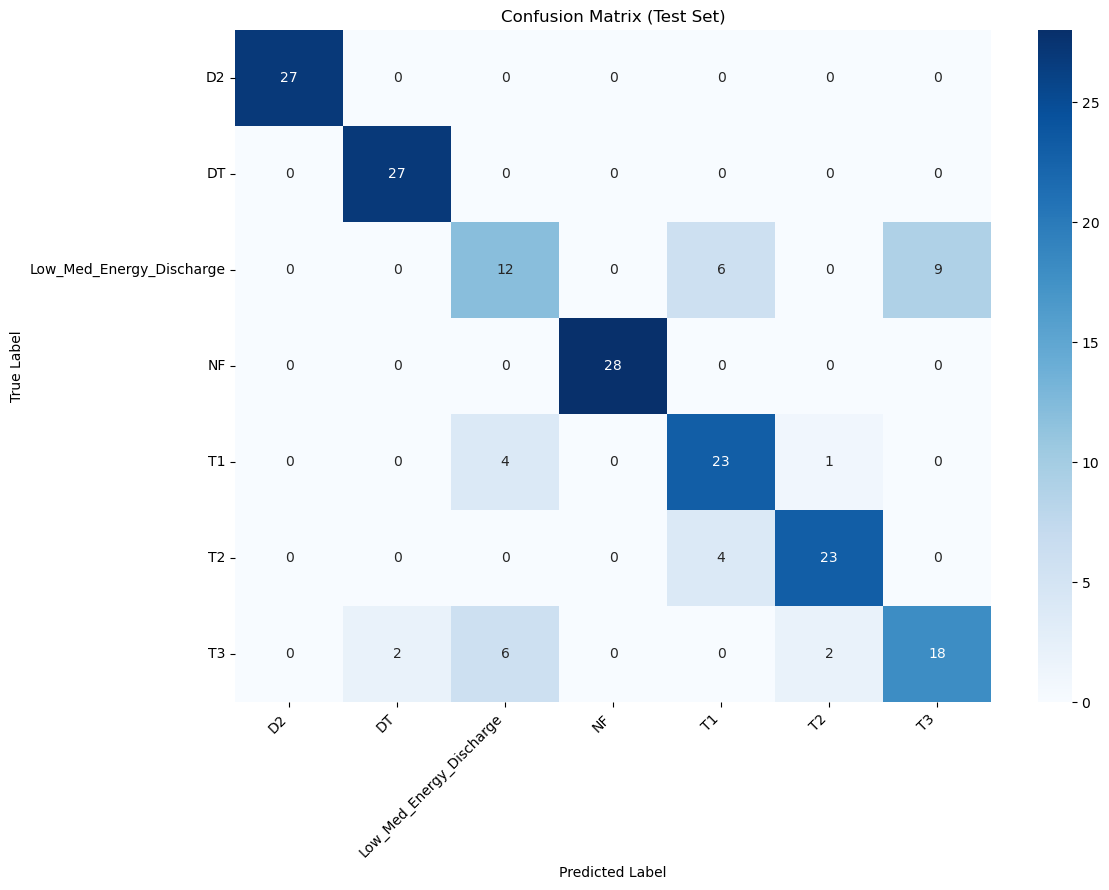

In [ ]:
# --- Evaluation on Test Set ---
if 'final_model' in locals() and 'test_loader_final' in locals() and \
   'label_encoder' in locals() and 'DEVICE' in locals() and \
   hasattr(label_encoder, 'classes_'): # Ensure label_encoder is fitted
    logging.info("--- Evaluating Final Model on Test Set ---")
    print("\n--- Evaluating Final Model on Test Set ---")

    try:
        final_model.to(DEVICE)
        final_model.load_state_dict(torch.load('best_fault_analysis_model.pt', map_location=DEVICE, weights_only=True))
        logging.info("Successfully loaded best_fault_analysis_model.pt with weights_only=True")
    except Exception as e:
        logging.error(f"Error loading model state: {e}. Using model current in memory (if any).")

    final_model.eval()
    y_pred_test_encoded_list: List[int] = []
    y_true_test_encoded_list: List[int] = []

    with torch.no_grad():
        for X_batch_test, y_batch_test in test_loader_final:
            X_batch_test = X_batch_test.to(DEVICE) # Corrected
            y_batch_test = y_batch_test.to(DEVICE) # Corrected
            outputs = final_model(X_batch_test)
            _, predicted = torch.max(outputs.data, 1)
            y_pred_test_encoded_list.extend(predicted.cpu().numpy())
            y_true_test_encoded_list.extend(y_batch_test.cpu().numpy())

    if y_true_test_encoded_list and y_pred_test_encoded_list:
        y_pred_test_text = label_encoder.inverse_transform(y_pred_test_encoded_list)
        y_true_test_text = label_encoder.inverse_transform(y_true_test_encoded_list)

        test_accuracy = accuracy_score(y_true_test_text, y_pred_test_text)
        test_f1_w = f1_score(y_true_test_text, y_pred_test_text, average='weighted', zero_division=0)
        test_f1_m = f1_score(y_true_test_text, y_pred_test_text, average='macro', zero_division=0)

        logging.info(f"Test Accuracy: {test_accuracy:.4f}, F1(W): {test_f1_w:.4f}, F1(M): {test_f1_m:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}\nTest F1-Score (Weighted): {test_f1_w:.4f}\nTest F1-Score (Macro): {test_f1_m:.4f}")

        report_target_names: List[str] = list(label_encoder.classes_)
        print("\nClassification Report (Test Set):\n")
        # Ensure class_report_str is indeed a string
        class_report_obj = classification_report(
            y_true_test_text, y_pred_test_text, labels=report_target_names,
            target_names=report_target_names, zero_division=0, output_dict=False # Explicitly string
        )
        class_report_str = str(class_report_obj) # Ensure it's a string for logging
        print(class_report_str)
        logging.info(f"\nClassification Report (Test Set):\n{class_report_str}") # Use f-string

        cm = confusion_matrix(y_true_test_text, y_pred_test_text, labels=report_target_names)
        plt.figure(figsize=(12, 9))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=report_target_names, yticklabels=report_target_names, cmap='Blues')
        plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix (Test Set)')
        plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
        plt.savefig('confusion_matrix_final_test_set.png')
        logging.info("Saved final confusion matrix.")
        plt.show()
        plt.close()
    else:
        logging.warning("Test set evaluation yielded no results. Skipping metrics.")
        print("Test set evaluation yielded no results. Skipping metrics.")
else:
    logging.warning("Prerequisites for test set evaluation not met. Skipping.")
    print("\nPrerequisites for test set evaluation not met. Skipping.")